In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


# Strava segment recommender

In [2]:
import pandas as pd
import stravalib
from mpl_toolkits.basemap import Basemap

## Get data from Strava Public API

In [294]:
client = stravalib.Client(access_token='ea571a903a95d27a567aadfaeb85d8e76aeafee3')

### Get IDs of popular Bay Area segments

`Client.explore_segments` is limited to returning only 10 (of the most popular) segments per request. To get the most popular segments over a large area of the map, we can place a grid on the desired map area and make a request for each square of the grid.

In [295]:
# lat/lon bounds for the whole region of interest (South SF Bay Area)
bounds = dict(llcrnrlat=36.8, llcrnrlon=-122.6, 
              urcrnrlat=38.0, urcrnrlon=-121.6)

Now, define the grid...

In [296]:
gridlines = 15 # number of grid lines to use
gridlat = linspace(bounds['llcrnrlat'], bounds['urcrnrlat'], gridlines)
gridlon = linspace(bounds['llcrnrlon'], bounds['urcrnrlon'], gridlines)

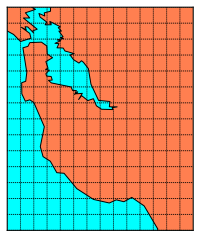

In [6]:
mp = Basemap(resolution='i', **bounds)
mp.fillcontinents(color='coral', lake_color='aqua')
mp.drawmapboundary(fill_color='aqua')
mp.drawcoastlines()
mp.drawparallels(gridlat)
mp.drawmeridians(gridlon);

In [297]:
gridsquares = [(south, west, north, east)
               for (south, north) in zip(gridlat[:-1], gridlat[1:])
               for (west, east) in zip(gridlon[:-1], gridlon[1:])]

In [ ]:
segments = [(segment.id, segment.name)
            for gridsquare in gridsquares
            for segment in client.explore_segments(gridsquare)]

segments = pd.DataFrame.from_records(segments, columns=['id','name'], index='id')
segments.head()

In [361]:
#segments.to_csv('segments.csv')
segments = pd.read_csv('segments.csv').set_index('id')

In [362]:
segments.head()

,name
id,
4236635,Pacific Coast Bike Route: Thurwachter to Jensen
658876,Trafton
5086842,Hilltop Rd Salinas to Jenson
4236698,Pacific Coast Bike Route: Jensen to Thurwachter
998126,Trafton Road Bump


### Get segment leaderboards

In [ ]:
leaderboards = [client.get_segment_leaderboard(segment_id, top_results_limit=100) 
                for segment_id in segments['id']]

In [ ]:
len(leaderboards)

In [ ]:
columns = ['activity_id','athlete_id','average_hr',
           'average_watts','effort_id','elapsed_time',
           'moving_time','rank','start_date']

In [ ]:
def leaderboard_to_df(leaderboard, fields):

    records = [[entry.__getattribute__(x) for x in fields]
               for entry in leaderboard]
    
    df = pd.DataFrame.from_records(records, columns=fields)
    return df.convert_objects().set_index('athlete_id')

In [ ]:
leaders = [leaderboard_to_df(lb, columns) for lb in leaderboards]
leaders = pd.concat(leaders, keys=segment_ids, names=['segment_id'])

In [353]:
leaders.head()

activity_id  average_hr  average_watts   effort_id  \
segment_id athlete_id                                                       
98         241840        301272007         NaN          376.9  7087798624   
           637337         84869449         NaN          377.9  1743456704   
           31292         324702550         NaN          332.7  7679192006   
           8777           73686159       169.4          245.5  1456747437   
           1689588        42595690         NaN            NaN   716076628   

                       elapsed_time  moving_time  rank          start_date  
segment_id athlete_id                                                       
98         241840          00:10:39     00:09:06     1 2015-05-09 19:25:05  
           637337          00:10:41     00:10:41     2 2013-09-25 15:04:41  
           31292           00:11:13     00:11:13     3 2015-06-13 17:12:40  
           8777            00:11:52     00:11:52     4 2013-08-10 18:38:09  
           1689588         00:12:02     00:12:02     5 2013-02-28 20:06:25

In [352]:
#leaders.to_hdf('leaders.h5', 'leaders')
leaders = pd.read_hdf('leaders.h5', 'leaders')

# Building a recommender system

In [186]:
leaders = leaders.groupby(level='athlete_id').filter(lambda x: len(x) > 3)
leaders = leaders.groupby(level='segment_id').filter(lambda x: len(x) > 3)

In [187]:
leaders['rank'].head()

segment_id  athlete_id
98          637337        2
            31292         3
            8777          4
            1689588       5
            2507490       6
Name: rank, dtype: float64

In [188]:
norm_rank = (leaders['rank'].groupby(level='segment_id')
                            .transform(lambda x: (x-1)/(len(x)-1)))

In [190]:
score = (norm_rank.groupby(level='athlete_id')
                  .transform(lambda x: (x - x.mean())/x.std())
                  .sortlevel())

score.name = 'score'

In [192]:
score.head()

segment_id  athlete_id
98          8             1.011239
            45           -0.540634
            2519          1.972199
            5349          0.733317
            5580          0.373971
Name: score, dtype: float64

In [282]:
df = score.reset_index()
df['segment'] = df.segment_id.rank(method='dense')
df['athlete'] = df.athlete_id.rank(method='dense')
df = df.reindex(permutation(df.index)).reset_index(drop=True)

In [284]:
df.head()

,segment_id,athlete_id,score,segment,athlete
0,642780,165048,-0.117106,202,2485
1,3564552,3804864,-1.048239,812,6734
2,3005325,10648,0.049176,740,759
3,1850319,1834251,-1.050982,622,5864
4,1494737,806075,-0.022325,553,4786


# Collaborative filtering

In [285]:
import scipy.sparse as sparse
from cofi import roll_params, unroll_params
from scipy.optimize import fmin_cg

In [415]:
X = df[['segment','athlete']].values.astype(int) - 1
y = df.score.values

In [416]:
Y = sparse.coo_matrix((y, (X[:,0], X[:,1]))).todense()
R = sparse.coo_matrix((ones_like(y), (X[:,0], X[:,1]))).todense()

In [417]:
Y.shape

(1431, 7238)

In [199]:
sum(Y != 0) / Y.size

0.011311910950610269

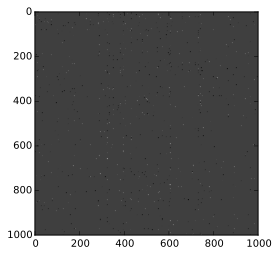

In [200]:
imshow(Y[:1000,:1000], interpolation='nearest', cmap=cm.gray);

In [201]:
def cofi_cost(params, Y, R, λ, num_users, num_items, num_features=30):
    
    """Regularized cost function and gradient for collaborative filtering"""
    
    X, Θ = unroll_params(params, num_users, num_items, num_features)
    
    D = where(R, dot(X, Θ.T) - Y, 0)
    J = 0.5*(sum(D**2) + λ*(sum(Θ**2) + sum(X**2)))
    
    return J


def cofi_cost_grad(params, Y, R, λ, num_users, num_items, num_features=30):
    
    """Gradient of regularized cost function for collaborative filtering"""
    
    X, Θ = unroll_params(params, num_users, num_items, num_features)
    
    D = where(R, dot(X, Θ.T) - Y, 0)
    X_grad = dot(D, Θ) + λ*X
    Θ_grad = dot(D.T, X) + λ*Θ
    
    return roll_params(X_grad, Θ_grad)

In [202]:
num_features = 10         # analog of action, comedy, romance, etc.
num_segments = Y.shape[0] # analog of movies
num_athletes = Y.shape[1] # analog of users

In [203]:
num_params = (num_athletes + num_segments)*num_features
params_test = rand(num_params)

In [204]:
cofi_cost(params_test, Y, R, 1, num_athletes, num_segments, num_features)

465620.35574790178

## Gradient checking

In [205]:
def cofi_cost_grad_check(params, eps, n=None, *args, **kw):
    
    grad = np.empty_like(params)
    
    if n is None:
        n = len(params)
    
    for i in range(n):
        params[i] -= eps
        J0 = cofi_cost(params, *args, **kw)
        params[i] += 2*eps
        J1 = cofi_cost(params, *args, **kw)
        params[i] -= eps
        grad[i] = (J1 - J0)/(2*eps)
        
    return grad

In [206]:
grad = cofi_cost_grad(params_test, Y, R, 1, num_athletes, num_segments, num_features)

In [207]:
check = cofi_cost_grad_check(params_test, 1e-6, 100,
                             Y, R, 1, num_athletes, num_segments, num_features)

In [208]:
allclose(grad[:100], check[:100])

True

## Complete algorithm

In [209]:
from cofi import StatusPrinter # callback to print cost at each iteration
from sklearn.base import BaseEstimator

class CollaborativeFiltering(BaseEstimator):
    
    def __init__(self, num_users, num_items, 
                 num_features=10, lm=0, maxiter=100):
        
        self.num_users = num_users
        self.num_items = num_items
        self.num_features = num_features
        self.lm = lm
        self.maxiter = maxiter
        
        # arguments to pass to the cost function
        self.args = (Y, R, self.lm, self.num_users, self.num_items, self.num_features)
        
    def fit(self, X, y, progress=False, **kw):
        
        # construct Y matrix
        Y = sparse.coo_matrix((y, (X[:,0], X[:,1]))).todense()
        R = sparse.coo_matrix((ones(X.shape[0]), (X[:,0], X[:,1]))).todense()
        
        # initialize parameters randomly
        num_params = (self.num_users + self.num_items)*self.num_features
        params_initial = randn(num_params)
        
        # set parameters for minimization routine
        
        params = dict(disp=False)
        params.update(kw)
        
        if progress:
            params['callback'] = StatusPrinter(cofi_cost, self.args)
        
         # minimize cost using conjugate gradient
        
        params_optimal = fmin_cg(cofi_cost, params_initial, 
                                 cofi_cost_grad, self.args, 
                                 maxiter=self.maxiter, **params)
        
        X, Θ = unroll_params(params_optimal, 
                             self.num_users, 
                             self.num_items, 
                             self.num_features)

        self.H_ = dot(X, Θ.T)
        return self
        
    def predict(self, X):
        return self.H_[X[:,0], X[:,1]]

In [210]:
est = CollaborativeFiltering(num_athletes, num_segments, num_features=10, lm=1)

In [211]:
est.fit(X, y, progress=True)

iteration 1, cost = 116221.38042518207
iteration 2, cost = 78564.87806091682
iteration 3, cost = 70467.53488570957
iteration 4, cost = 65863.56743108822
iteration 5, cost = 55913.06484426811
iteration 6, cost = 46328.577856524236
iteration 7, cost = 41400.63914117526
iteration 8, cost = 36364.33919407551
iteration 9, cost = 33576.79647888923
iteration 10, cost = 31574.291760328506
iteration 20, cost = 25620.037707604486
iteration 30, cost = 24228.804787422418
iteration 40, cost = 23579.794578627985
iteration 50, cost = 23112.51706076857
iteration 60, cost = 22821.85818596088
iteration 70, cost = 22658.21766229917
iteration 80, cost = 22430.154598118905
iteration 90, cost = 22322.398844846364
iteration 100, cost = 22229.21745005595


CollaborativeFiltering(lm=1, maxiter=100, num_features=10, num_items=1431,
            num_users=7238)

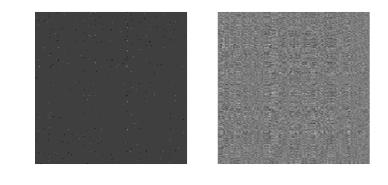

In [217]:
fig, ax = subplots(1, 2)
ax[0].imshow(Y[:1000,:1000], interpolation='nearest', cmap=cm.gray)
ax[1].imshow(est.H_[:1000,:1000], interpolation='nearest', cmap=cm.gray)
ax[0].axis('off')
ax[1].axis('off');

## Taking advantage of sparseness

The above code is a bit slow for the amount of data we're working with here. In fact the above code is pretty wasteful since it uses ordinary matrix multiplication when the matrices we're dealing with are very sparse. We can get major time and space savings by taking advantage of the sparse nature of the problem. For the remainder of this experiment I'll use a more efficient version of the code written in Cython ([here](https://github.com/mcwitt/segment-recommender/blob/master/cofi/cofi.pyx)) which substitutes loops over nonzero elements for matrix operations to take advantage of the sparseness of `Y`.

In [218]:
from cofi import CollaborativeFiltering
from cofi import cost as cofi_cost2
from cofi import cost_grad as cofi_cost_grad2

In [219]:
timeit cofi_cost(params_test, Y, R, 1, num_athletes, num_segments, num_features)

10 loops, best of 3: 117 ms per loop


In [220]:
timeit cofi_cost2(params_test, X[:,0], X[:,1], y, len(y), 1, num_athletes, num_segments, num_features)

100 loops, best of 3: 6.06 ms per loop


In [221]:
allclose(cofi_cost(params_test, Y, R, 1, num_athletes, num_segments, num_features),
         cofi_cost2(params_test, X[:,0], X[:,1], y, len(y), 1, num_athletes, num_segments, num_features))

True

In [222]:
allclose(cofi_cost_grad(params_test, Y, R, 1, num_athletes, num_segments, num_features),
         cofi_cost_grad2(params_test, X[:,0], X[:,1], y, len(y), 1, num_athletes, num_segments, num_features))

True

# Cross-validation

## Model selection: Regularization parameter

In [223]:
from sklearn.learning_curve import learning_curve, validation_curve

In [251]:
est = CollaborativeFiltering(num_athletes, num_segments, num_features=10)

In [252]:
lm = linspace(6, 16, 20)

train_scores, valid_scores =\
    validation_curve(est, X, y, 'lm', lm,
                     scoring='mean_squared_error',
                     cv=8, n_jobs=4)

In [253]:
def plot_cv_scores(x, test_scores, train_scores=None, ax=None):
    
    if ax is None:
        ax = gca()
    
    def _plot(x, scores, **kw):
        score_mean = scores.mean(axis=1)
        score_std = scores.std(axis=1)
        ax.plot(x, score_mean, **kw)
        
        ax.fill_between(x, 
                        score_mean - score_std,            
                        score_mean + score_std,
                        alpha=0.3)
        
    if train_scores is not None:
        _plot(x, train_scores, label='train', color='b', marker='o')
        
    _plot(x, valid_scores, label='test', color='g', marker='s')

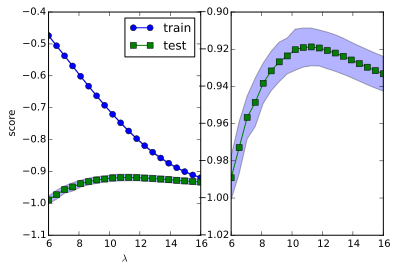

In [254]:
fig, (axl, axr) = subplots(1, 2, sharex=True)
plot_cv_scores(lm, valid_scores, train_scores, ax=axl)
plot_cv_scores(lm, valid_scores, ax=axr)
axl.set_xlabel('$\lambda$')
axl.set_ylabel('score')
axl.legend();

In [255]:
est = CollaborativeFiltering(num_athletes, num_segments, lm=10)

## Model selection: number of features

In [256]:
num_features = [1,2,4,8,16,32,64]

train_scores, valid_scores =\
    validation_curve(est, X, y, 'num_features', num_features,
                     scoring='mean_squared_error', 
                     cv=8, n_jobs=4)

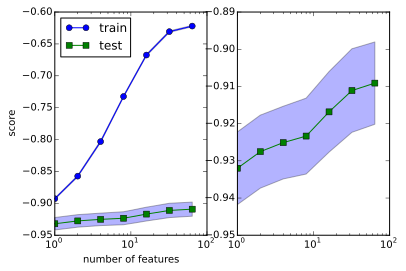

In [257]:
fig, (axl, axr) = subplots(1, 2, sharex=True)
plot_cv_scores(num_features, valid_scores, train_scores, ax=axl)
plot_cv_scores(num_features, valid_scores, ax=axr)
axl.set_xscale('log')
axr.set_xscale('log')
axl.set_xlabel('number of features')
axl.set_ylabel('score')
axl.legend(loc=2);

In [246]:
est = CollaborativeFiltering(num_athletes, num_segments, num_features=10, lm=10)

# Learning curves

In [ ]:
learning_curve()

In [258]:
train_sizes, train_scores, valid_scores =\
    learning_curve(est, X, y,
                   train_sizes=logspace(-2,0,20),
                   scoring='mean_squared_error', 
                   cv=8, n_jobs=4)

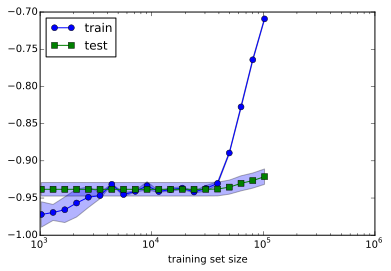

In [259]:
plot_cv_scores(train_sizes, valid_scores, train_scores)
xscale('log')
xlabel('training set size')
legend(loc=2);

# Find similar segments

In [363]:
segments[segments.name.str.contains('Charlie')]

,name
id,
646647,Mt Charlie Climb
4102842,Mount Charlie Descent


In [365]:
df[df.segment_id == 646647].segment.iloc[0]

222.0

In [465]:
est = CollaborativeFiltering(num_athletes, num_segments, num_features=30, lm=10, maxiter=10000)
segment_features = est.fit(X, y).X_

In [481]:
segment_features_normed = (segment_features / 
                           tile(sqrt(sum(segment_features**2, axis=1)), (segment_features.shape[1],1)).T)

In [482]:
charlie_vec = segment_features[222,:]

In [488]:
dot(segment_features, segment_features.T).shape

(1431, 1431)

In [483]:
similarity = dot(segment_features, charlie_vec)

In [484]:
similar_segments = [(df[df.segment == segment].segment_id.iloc[0], similarity[segment])
                    for segment in argsort(similarity)[::-1][:10]]

In [485]:
pd.DataFrame.from_records([(sid, segments.name.loc[sid], similarity) 
                           for sid, similarity in similar_segments if sid in segments.index],
                          columns=['id','name','similarity'])

,id,name,similarity
0,646647,Mt Charlie Climb,1.384699
1,630146,Tassajara Lump,0.651514
2,953502,Carpenteria- San Juan to Seely,0.630642
3,781767,Sycamore Valley Rd Headwind Pull from Tassjara...,0.615667
4,3418564,from the parking lot of the county park,0.603940
5,4554906,to bay test,0.582470
6,1462453,XXXDH,0.569239
7,6512075,S. White Rd - Quimby to Aborn,0.537080
8,6790429,New Bike Path Sprint,0.533637
9,617863,Clayton Rd,0.531442
